# Probpipe Distribution module

In [3]:
from pathlib import Path
import sys

# Walk up until we find the repo root that contains the 'probpipe' folder
p = Path.cwd()
while p != p.parent and not (p / "probpipe").exists():
    p = p.parent

sys.path.insert(0, str(p))  # add repo root to import path

# Univariate Normal Distribution


In [8]:
from probpipe.core.distributions.multivariate import Normal1D


In [10]:
import numpy as np
from numpy.typing import NDArray
from scipy.stats import norm
import matplotlib.pyplot as plt

In [11]:
rng = np.random.default_rng(123)

## 1) Constructing a Normal1D

In [12]:
dist = Normal1D(mu=0.0, sigma=1.5, rng=rng)

print("mean():", dist.mean())     # -> (1,)
print("cov():\n", dist.cov())     # -> (1,1)

mean(): [0.]
cov():
 [[2.25]]


## 2) Sampling — sample(n) -> (n,1)

In [13]:
xs = dist.sample(5)
print(xs.shape)      # (5, 1)
print(xs[:3].ravel())

(5, 1)
[-1.48368203 -0.55167998  1.93188789]


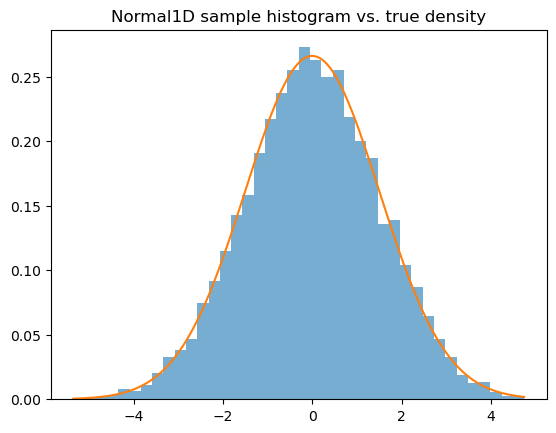

In [14]:
xs_big = dist.sample(5000)
plt.hist(xs_big[:,0], bins=40, density=True, alpha=0.6)
grid = np.linspace(xs_big.min(), xs_big.max(), 400)
plt.plot(grid, norm(loc=dist.mu, scale=dist.sigma).pdf(grid))
plt.title("Normal1D sample histogram vs. true density");

## 3) Density & Log-Density — return shape (n,1)

In [15]:
# Single value, a 1-D vector, or a column vector all work:
vals_scalar = 0.0
vals_1d     = np.array([-2.0, 0.0, 1.0])      # (3,)
vals_col    = np.array([[-2.0],[0.0],[1.0]])  # (3,1)

p1 = dist.density(vals_scalar)   # -> (1,1)
p2 = dist.density(vals_1d)       # -> (3,1)
p3 = dist.density(vals_col)      # -> (3,1)

lp2 = dist.log_density(vals_1d)  # -> (3,1)

print("density(scalar):", p1.shape, p1.ravel())
print("density(1d):",    p2.shape, p2.ravel())
print("log_density(1d):",lp2.shape, lp2.ravel())

density(scalar): (1, 1) [0.26596152]
density(1d): (3, 1) [0.10934005 0.26596152 0.21296534]
log_density(1d): (3, 1) [-2.21329253 -1.32440364 -1.54662586]


## 4) CDF & Inverse CDF — cdf(x) and inv_cdf(u)

In [16]:
xs_test = np.array([-2.0, -0.5, 0.0, 0.5, 2.0])
F = dist.cdf(xs_test)     # -> (5,1)

# Inverse CDF: scalar, (n,), or (n,1) in [0,1]
Us = np.array([0.001, 0.25, 0.5, 0.75, 0.999])
Qs = dist.inv_cdf(Us)     # -> (5,1)

print("cdf shape:", F.shape, "\n", F.ravel())
print("inv_cdf shape:", Qs.shape, "\n", Qs.ravel())

# Quick roundtrip check: inv_cdf(cdf(x)) ≈ x
back = dist.inv_cdf(F)
print("Roundtrip max abs error:", np.max(np.abs(back[:,0] - xs_test)))

cdf shape: (5, 1) 
 [0.09121122 0.36944134 0.5        0.63055866 0.90878878]
inv_cdf shape: (5, 1) 
 [-4.63534846 -1.01173463  0.          1.01173463  4.63534846]
Roundtrip max abs error: 1.1102230246251565e-16


## 5) Expectation — Monte-Carlo CLT

In [17]:
# f(x) = x^2; we estimate E[X^2] and its standard error by MC, returning Normal1D(mean, se)
est = dist.expectation(lambda x: x[:,0]**2)  # scalar per sample
print("E[X^2] ~ Normal1D with mean, se:", est.mu, est.sigma)

E[X^2] ~ Normal1D with mean, se: 2.2384494260978585 0.07175290797013993


Why Normal1D? The expectation returns the sampling distribution of the Monte-Carlo estimator (mean ± SE), not the raw number. To get the point estimate only:

In [18]:
point_est = est.mu
print("Point estimate for E[X^2]:", point_est)

Point estimate for E[X^2]: 2.2384494260978585


## 5b) Vector-valued f(X) ⇒ returns MvNormal for the estimator of E[f(X)]

In [19]:
# f(x) = [x, x^2] (vector output per sample)
est_vec = dist.expectation(lambda x: np.column_stack([x[:,0], x[:,0]**2]))
print("Vector estimator mean:", est_vec.mean())
print("Vector estimator cov:\n", est_vec.cov())

Vector estimator mean: [-0.03083729  2.18922134]
Vector estimator cov:
 [[ 1.06901339e-03 -7.53683253e-05]
 [-7.53683253e-05  4.52274359e-03]]


## 6) Converting from another Distribution — from_distribution


Normal1D.from_distribution(other, n=...) draws samples from other.sample(n) and fits μ,σ.


In [21]:
class ToyTwoPoint:
    """Draws X = -1 with prob 0.3 and +2 with prob 0.7, returned as (n,1)."""
    def __init__(self, rng=None):
        self.rng = rng or np.random.default_rng()
    def sample(self, n: int) -> NDArray[np.floating]:
        p = 0.7
        draws = self.rng.random(n)
        x = np.where(draws < p, 2.0, -1.0)
        return x.reshape(-1,1)

toy = ToyTwoPoint(rng)
fit_norm = Normal1D.from_distribution(toy, n=5000)  # method flattens (n,1) to (n,) internally
print("Fit Normal1D mu, sigma:", fit_norm.mu, fit_norm.sigma)

Fit Normal1D mu, sigma: 1.1006 1.3746481628090523


Check that fitted μ,σ are close to the true mean/SD:

True mean = 0.72 + 0.3(-1) = 1.1

True variance = E[X²] − μ² = (0.74 + 0.31) − 1.1² = (2.8 + 0.3) − 1.21 = 1.89 ⇒ σ ≈ 1.3748

# Multivariate Normal Distribution

In [23]:
from probpipe.core.distributions.multivariate import MvNormal

In [24]:
from scipy.stats import multivariate_normal as sp_mvn, norm

## 1) Constructing an MvNormal

In [25]:
mu  = np.array([0.0, 1.0, -1.0])     # (d,)
cov = np.array([[ 2.00,  0.10, -0.30],
                [ 0.10,  1.50,  0.25],
                [-0.30,  0.25,  3.00]])  # (d,d), SPD

mvn = MvNormal(mean=mu, cov=cov, rng=rng)

print("dimension:", mvn.dimension)    # -> d
print("mean():",   mvn.mean())        # -> (d,)
print("cov():\n",  mvn.cov())         # -> (d,d)

dimension: 3
mean(): [ 0.  1. -1.]
cov():
 [[ 2.    0.1  -0.3 ]
 [ 0.1   1.5   0.25]
 [-0.3   0.25  3.  ]]


## 2) Sampling — sample(n) -> (n,d)

In [26]:
X = mvn.sample(5)
print(X.shape)    # (5, d)
print(X[:2])

(5, 3)
[[-1.1367071  -0.89067076  0.65045449]
 [ 0.42182375  1.53341228 -3.88383403]]


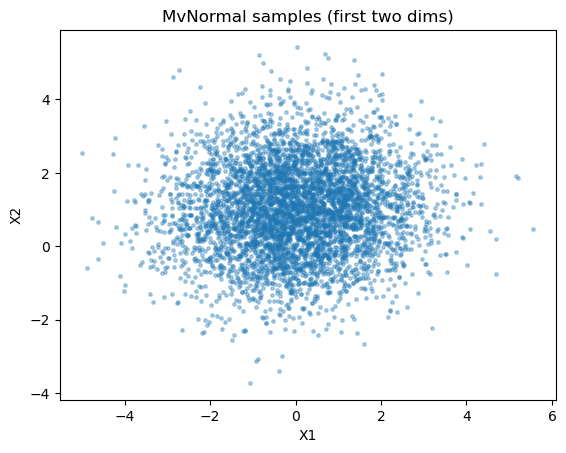

In [27]:
X_big = mvn.sample(5000)
plt.scatter(X_big[:,0], X_big[:,1], s=6, alpha=0.35)
plt.xlabel("X1"); plt.ylabel("X2"); plt.title("MvNormal samples (first two dims)");

## 3) Density & Log-Density — return (n,1)

In [28]:
# Accepts (d,) or (n,d)
x_single = mu + np.array([0.2, -0.3, 0.5])
x_batch  = mu + np.array([[ 0.0,  0.0,  0.0],
                          [ 1.0, -1.0,  0.5],
                          [-0.5, 0.2,  -1.2]])

p1 = mvn.density(x_single)     # -> (1,1)
pB = mvn.density(x_batch)      # -> (3,1)
lB = mvn.log_density(x_batch)  # -> (3,1)

print("density(single):", p1.shape, p1.ravel())
print("density(batch):",  pB.shape, pB.ravel())
print("log_density:",      lB.shape, lB.ravel())

density(single): (1, 1) [0.01946453]
density(batch): (3, 1) [0.02153255 0.01028447 0.01477398]
log_density: (3, 1) [-3.83818967 -4.57712009 -4.21488749]


Consistency vs SciPy:

In [29]:
p_scipy = sp_mvn(mean=mu, cov=cov).pdf(x_batch)  # -> (3,)
print("max|diff| vs SciPy pdf:", np.max(np.abs(pB[:,0] - p_scipy)))

max|diff| vs SciPy pdf: 0.0


## 4) CDF — cdf(x) -> (n,1)

In [30]:
F = mvn.cdf(x_batch)    # -> (3,1)
print(F.shape, F.ravel())

(3, 1) [0.12922627 0.10694246 0.04853836]


## 5) Inverse CDF (Rosenblatt) — inv_cdf(u) -> (n,d)


Input u: (d,) or (n,d) with entries in (0,1).

Output has event shape (n,d).

In [31]:
U_one   = np.array([0.05, 0.50, 0.95])     # (d,)
U_batch = np.vstack([U_one,
                     np.array([0.2, 0.8, 0.4])])

x_from_u1 = mvn.inv_cdf(U_one)    # -> (d,)
x_from_uB = mvn.inv_cdf(U_batch)  # -> (2,d)

print("inv_cdf(one):",  x_from_u1.shape, x_from_u1)
print("inv_cdf(batch):",x_from_uB.shape, x_from_uB)

inv_cdf(one): (3,) [-2.32617431  0.88369128  2.15388475]
inv_cdf(batch): (2, 3) [[-2.32617431  0.88369128  2.15388475]
 [-1.19023216  1.9695403  -1.07108921]]


Sanity: probability integral transform (approximate):


Generate many U ~ Uniform(0,1)^d, map through inv_cdf, then check sample mean/cov.

In [32]:
U = rng.random((4000, mvn.dimension))
X_from_U = mvn.inv_cdf(U)
print("mean ~", X_from_U.mean(axis=0))
print("cov  ~\n", np.cov(X_from_U, rowvar=False))

mean ~ [ 0.00498092  1.01979806 -0.9997958 ]
cov  ~
 [[ 2.05864546  0.09197255 -0.35903037]
 [ 0.09197255  1.527468    0.29095405]
 [-0.35903037  0.29095405  3.00869337]]


## 6) Expectation — Monte-Carlo CLT over f(X)

### 6a) Scalar f ⇒ returns Normal1D(mean, se)

In [33]:
# f(x) = x1 * x2  (scalar)
est_scalar = mvn.expectation(lambda X: X[:,0] * X[:,1])
print("Scalar estimator ~ Normal1D(mean, se):", est_scalar.mu, est_scalar.sigma)

# For the point estimate only:
print("Point estimate E[X1*X2] ≈", est_scalar.mu)

Scalar estimator ~ Normal1D(mean, se): 0.11207592943041354 0.047543488337896504
Point estimate E[X1*X2] ≈ 0.11207592943041354


### 6b) Vector f ⇒ returns MvNormal(mean, cov_of_mean)

In [34]:
# f(x) = [x1, x2, x3, x1*x2]
est_vec = mvn.expectation(lambda X: np.column_stack([X[:,0], X[:,1], X[:,2], X[:,0]*X[:,1]]))
print("Vector estimator mean (4,):", est_vec.mean())
print("Vector estimator cov (4x4):\n", est_vec.cov())

Vector estimator mean (4,): [-0.05130036  1.03266843 -0.98017943  0.01176773]
Vector estimator cov (4x4):
 [[ 9.74125760e-04  3.16287212e-05 -1.63381531e-04  1.05903507e-03]
 [ 3.16287212e-05  7.26261016e-04  1.26662968e-04 -2.26184035e-05]
 [-1.63381531e-04  1.26662968e-04  1.47734577e-03 -1.66740559e-04]
 [ 1.05903507e-03 -2.26184035e-05 -1.66740559e-04  2.56136858e-03]]


## 7) Fitting from Another Distribution — from_distribution

In [35]:
class ToyMixture:
    """
    Mixture of two 3D Gaussians, returns (n,d).
    """
    def __init__(self, rng=None):
        self.rng = rng or np.random.default_rng(0)
        self.mu1 = np.array([0.0, 0.0, 0.0])
        self.S1  = np.eye(3)
        self.mu2 = np.array([2.0, -1.0, 1.5])
        self.S2  = np.array([[1.2, 0.3, 0.0],
                             [0.3, 2.0, 0.2],
                             [0.0, 0.2, 1.5]])
        self.w   = 0.65
        self._m1 = sp_mvn(mean=self.mu1, cov=self.S1)
        self._m2 = sp_mvn(mean=self.mu2, cov=self.S2)

    def sample(self, n: int) -> NDArray[np.floating]:
        z = self.rng.random(n) < self.w
        n1 = int(z.sum())
        n2 = n - n1
        x1 = self._m1.rvs(size=n1, random_state=self.rng)
        x2 = self._m2.rvs(size=n2, random_state=self.rng)
        X  = np.vstack([x1, x2])
        self.rng.shuffle(X, axis=0)
        return np.asarray(X, dtype=float)

mix = ToyMixture(rng)
mvn_fit = MvNormal.from_distribution(mix, n=6000)
print("Fitted mean:", mvn_fit.mean())
print("Fitted cov:\n", mvn_fit.cov())

Fitted mean: [ 0.72121324 -0.34214365  0.51221117]
Fitted cov:
 [[ 1.99325029 -0.35350626  0.71657993]
 [-0.35350626  1.58810164 -0.27727701]
 [ 0.71657993 -0.27727701  1.69499392]]
